<a href="https://colab.research.google.com/github/jdasam/aat3020-2023/blob/main/notebooks/1_Word2Vec_training_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import string

In [ ]:
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt"

--2023-03-14 14:37:18--  https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439742 (429K) [text/plain]
Saving to: ‘J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt.3’

J. K. Rowling - Har 100%[===================>] 429.44K  --.-KB/s    in 0.05s   

2023-03-14 14:37:18 (8.10 MB/s) - ‘J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt.3’ saved [439742/439742]



In [2]:
def remove_punctuation(x):
  return x.translate(''.maketrans('', '', string.punctuation))

def make_tokenized_corpus(corpus):
  out= [ [y.lower() for y in remove_punctuation(sentence).split(' ') if y] for sentence in corpus]
  return [x for x in out if x!=[]]

In [3]:
with open("J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt", 'r') as f:
  strings = f.readlines()
sample_text = "".join(strings).replace('\n', ' ').replace('Mr.', 'mr').replace('Mrs.', 'mrs').split('. ')


In [4]:
corpus = make_tokenized_corpus(sample_text)
corpus[1]

['they',
 'were',
 'the',
 'last',
 'people',
 'youd',
 'expect',
 'to',
 'be',
 'involved',
 'in',
 'anything',
 'strange',
 'or',
 'mysterious',
 'because',
 'they',
 'just',
 'didnt',
 'hold',
 'with',
 'such',
 'nonsense']

In [5]:
from collections import Counter

def get_entire_words(corpus):
  return sorted(list(set([y for x in corpus for y in x])))

def word_to_idx(unique_word_list):
  return {x:i for i, x in enumerate(unique_word_list)}

entire_words = get_entire_words(corpus)
print(f"Num entire unique words: {len(entire_words)}")
# filter by min count
word_counter = Counter([y for x in corpus for y in x])
min_count = 2
entire_words = [x for x in entire_words if word_counter[x] >= min_count]
print(f"Num entire unique words after filtering: {len(entire_words)}")
word_to_idx_dict = word_to_idx(entire_words)

Num entire unique words: 6038
Num entire unique words after filtering: 3450


In [87]:
def make_word_pair(corpus, window_size=3):
  pair_list = []
  for sentence in corpus:
    for i, word in enumerate(sentence):
      if word not in word_to_idx_dict:
          continue
      for j in range(max(i-window_size, 0), min(i+window_size+1, len(sentence))):
        if j==i:
          continue
        context_word = sentence[j]
        if context_word not in word_to_idx_dict:
          continue
        pair_list.append((word, context_word))
  return pair_list
pair_list = make_word_pair(corpus)
print(len(pair_list))

383314


In [8]:
pair_list[100]

('number', 'privet')

In [10]:
def make_word_pair_for_cbow(corpus, window_size=3):
  pair_list = []
  for sentence in corpus:
    for i, word in enumerate(sentence):
      context_words_for_wrd = []
      for j in range(max(i-window_size, 0), min(i+window_size+1, len(sentence))):
        if j==i:
          continue
        context_word = sentence[j]
        context_words_for_wrd.append(context_word)
      pair_list.append((word, context_words_for_wrd))
  return pair_list
# pair_list = make_word_pair_for_cbow(corpus)
# pair_list[10]

('who', ['one', 'the', 'boy', 'lived', 'mr', 'and'])

In [ ]:
pair_list[:20]

[('harry', 'potter'),
 ('harry', 'and'),
 ('harry', 'the'),
 ('potter', 'harry'),
 ('potter', 'and'),
 ('potter', 'the'),
 ('potter', 'sorcerers'),
 ('and', 'harry'),
 ('and', 'potter'),
 ('and', 'the'),
 ('and', 'sorcerers'),
 ('and', 'stone'),
 ('the', 'harry'),
 ('the', 'potter'),
 ('the', 'and'),
 ('the', 'sorcerers'),
 ('the', 'stone'),
 ('the', 'chapter'),
 ('sorcerers', 'potter'),
 ('sorcerers', 'and')]

In [ ]:
len(pair_list)

409784

In [102]:
num_vocab = len(word_to_idx_dict)
dim_emb = 6

word_u_mat = torch.randn(num_vocab, dim_emb, requires_grad=True)
word_v_mat = torch.randn(num_vocab, dim_emb, requires_grad=True)


In [20]:
entire_words[-1]

'zooming'

In [23]:
# torch.set_printoptions(sci_mode=False)
word_v_mat

tensor([[     1.6696,      0.6810,     -0.2639,     -0.9322,     -0.8922,
              1.1779],
        [    -1.1988,      1.0616,      0.8675,     -1.3824,      1.5451,
              1.6551],
        [    -0.5214,     -2.4303,      1.1586,      0.3917,      1.2780,
              0.8494],
        ...,
        [    -0.5584,     -0.3446,     -2.2134,     -0.3034,     -0.1180,
             -0.5064],
        [    -0.9883,      0.1926,     -0.3121,     -0.0298,      0.3613,
              0.0003],
        [     0.1171,     -0.7308,      1.2259,     -0.4610,     -0.5555,
             -0.4505]], requires_grad=True)

In [46]:
pair = pair_list[0]
print(pair)

center_word = word_to_idx_dict[pair[0]]
window_word = word_to_idx_dict[pair[1]]
print(center_word, window_word)

center_vec = word_v_mat[center_word]
window_vec = word_u_mat[window_word]

dot_product = (center_vec * window_vec).sum()

on_entire_vocab = torch.mm(word_u_mat, center_vec.unsqueeze(1)) # torch.mm gets two tensors, both in 2Dim
# on_entire_vocab.shape
prob = torch.exp(dot_product) / torch.exp(on_entire_vocab).sum()
prob.item()

('harry', 'potter')
1328 2199


5.936393336014589e-06

In [98]:
def get_prob_from_pair(pair):
  center_word = word_to_idx_dict[pair[0]]
  window_word = word_to_idx_dict[pair[1]]

  center_vec = word_v_mat[center_word]
  window_vec = word_u_mat[window_word]

  dot_product = (center_vec * window_vec).sum()

  on_entire_vocab = torch.mm(word_u_mat, center_vec.unsqueeze(1)) # torch.mm gets two tensors, both in 2Dim
  prob = torch.exp(dot_product) / torch.exp(on_entire_vocab).sum()

  return -(prob + 1e-7).log()

# total_prob = 1
total_log_prob = 0
for pair in pair_list[:100]:
  prob = get_prob_from_pair(pair)
  # print(prob.item())
  # total_prob *= prob
  total_log_prob += prob
# total_log_prob.item()
total_log_prob /= 100
total_log_prob

# Now we want to minimize Negative Log-likelihood
total_log_prob.backward()
lr = 0.01
word_u_mat.data = word_u_mat.data - word_u_mat.grad * lr 
word_u_mat.grad = None
total_log_prob

tensor(10.6892, grad_fn=<DivBackward0>)

In [94]:
torch.log(torch.tensor(1e-10))

tensor(-inf)

In [107]:
from tqdm.auto import tqdm
num_iter = 5
loss_records = []
lr = 0.001

for i in range(num_iter):
  total_log_prob = 0
  for pair in tqdm(pair_list[:10000]):
    prob = get_prob_from_pair(pair)
    prob.backward()
    word_u_mat.data = word_u_mat.data - word_u_mat.grad * lr 
    word_v_mat.data = word_v_mat.data - word_v_mat.grad * lr
    word_u_mat.grad = None
    word_v_mat.grad = None
    loss_records.append(prob.item())


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

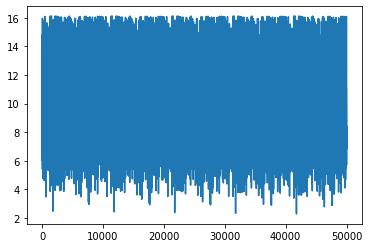

In [108]:
import matplotlib.pyplot as plt

plt.plot(loss_records)

In [109]:
sum(loss_records) / len(loss_records)

8.998295881476402

In [60]:
total_log_prob.backward()

In [64]:
lr = 1e-3 # 0.001
word_u_mat.data = word_u_mat.data - word_u_mat.grad * lr 
word_u_mat.grad = None

In [47]:
1 / len(entire_words)

0.0002898550724637681

In [42]:
example  =on_entire_vocab[:10]
example
exp_val = example.exp()
sum_exp_val = exp_val.sum()
softmax_val = exp_val / sum_exp_val
softmax_val 

tensor([[    0.0135],
        [    0.0001],
        [    0.0034],
        [    0.0019],
        [    0.0347],
        [    0.0554],
        [    0.8496],
        [    0.0062],
        [    0.0337],
        [    0.0014]], grad_fn=<DivBackward0>)

In [28]:
word_u_mat.shape, center_vec.shape

(torch.Size([3450, 6]), torch.Size([6]))

In [ ]:
from tqdm import tqdm
total_log_prob = 0
for i, pair in tqdm(enumerate(pair_list)):
  center_word = word_to_idx_dict[pair[0]]
  window_word = word_to_idx_dict[pair[1]]

  center_vec = word_v_mat[center_word]
  window_vec = word_u_mat[window_word]

  dot_product = (center_vec * window_vec).sum()

  on_entire_vocab = torch.matmul(center_vec, word_u_mat.T)
  prob = torch.exp(dot_product) / torch.exp(on_entire_vocab).sum(0)
  log_prob = -torch.log(prob+1e-8)
  total_log_prob += log_prob.item()
  break
total_log_prob /= len(pair_list)

0it [00:00, ?it/s]
